In [37]:
import numpy as np
import os
import pickle
import torch
import open_clip

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
all_datasets_path = "/scratch/kumaraditya_gupta/Datasets/mp3d_test"
dataset_name = "RPmz2sHmrrY"
seq_name = "sequence4"

dataset_path = os.path.join(all_datasets_path, dataset_name, seq_name)

gt_path = os.path.join(dataset_path, "gt.npy")
gt = np.load(gt_path) # (N, 8)

obj_nodes_path = os.path.join(dataset_path, "output_objs_v1", "scene_obj_nodes.pkl")
with open(obj_nodes_path, 'rb') as file:
    obj_nodes_dict = pickle.load(file)

/tmp/ipykernel_78265/1522727492.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(unique_room_ids))  # 'tab20' has 20 distinct colors
/home/kumaraditya_gupta/.conda/envs/instance-map/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


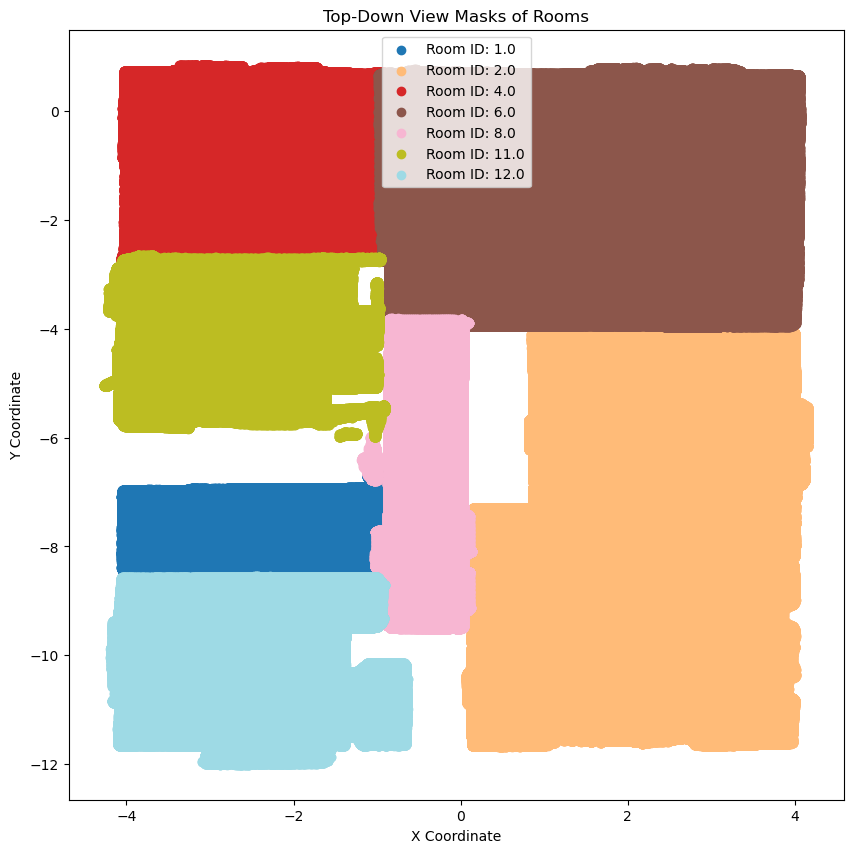

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt

# gt shape is (N, 8) and format [x, y, z, r, g, b, obj_id, room_id]

# Get the unique room IDs
unique_room_ids = np.unique(gt[:, -1])

# Create a colormap
colormap = plt.cm.get_cmap('tab20', len(unique_room_ids))  # 'tab20' has 20 distinct colors

# Initialize a dictionary to store mask coordinates for each room
room_masks = {}

# Create a figure for plotting
plt.figure(figsize=(10, 10))

# Iterate over each room ID and plot
for i, room_id in enumerate(unique_room_ids):
    # Filter points belonging to the current room
    room_points = gt[gt[:, -1] == room_id]

    # Extract x and y coordinates
    x, y = room_points[:, 0], room_points[:, 1]

    # Plot with a unique color
    plt.scatter(x, y, color=colormap(i), label=f'Room ID: {room_id}')

    # Store the mask in the dictionary
    room_masks[room_id] = (x, y)

# Add legend, title, and labels
plt.legend()
plt.title('Top-Down View Masks of Rooms')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Display the plot
plt.show()

# Save the plot
plt.savefig(f'{dataset_path}/all_floor_mask.png')

# Now room_masks dictionary contains the masks


In [3]:
# CLIP Model Loading and Preprocessing
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
        "ViT-H-14", "laion2b_s32b_b79k"
    )
clip_model = clip_model.to(device)
clip_tokenizer = open_clip.get_tokenizer("ViT-H-14")

In [22]:
# for every key in obj_nodes_dict, get the clip_embed and store it in a separate list for comparison later
obj_embeds_list = []
for node_id, node_data in obj_nodes_dict.items():
    obj_clip_embed = torch.Tensor(node_data['clip_embed'])
    obj_embeds_list.append(obj_clip_embed)

obj_embeds_tensor = torch.stack(obj_embeds_list, dim=0) # (N, 1024)
print(obj_embeds_tensor.shape)


torch.Size([101, 1024])


In [34]:
# Mapping of single-character labels to room names
label_to_room = {
    'a': 'bathroom',
    'b': 'bedroom',
    'd': 'dining room',
    'e': 'entryway',
    'g': 'garage',
    'h': 'hallway',
    'i': 'library',
    'j': 'laundry room',
    'k': 'kitchen',
    'l': 'living room',
    'm': 'meeting room',
    'n': 'lounge',
    'o': 'office',
    's': 'stairs',
    't': 'toilet',
    'u': 'utility room',
    'w': 'gym',
    'x': 'outdoor',
    'y': 'balcony',
    'C': 'classroom',
    'S': 'spa',
}

# Convert single-character labels to full room names
room_labels = list(label_to_room.values())

room_labels_tokens = clip_tokenizer(room_labels).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    room_labels_embeds = clip_model.encode_text(room_labels_tokens)
    room_labels_embeds /= room_labels_embeds.norm(dim=-1, keepdim=True)

room_labels_embeds = room_labels_embeds.cpu() # (M, 1024)
print(room_labels_embeds.shape)


torch.Size([21, 1024])


In [35]:
# Ensure both tensors are in the same dtype, for example, float32
obj_embeds_tensor = obj_embeds_tensor.to(dtype=torch.float32)
room_labels_embeds = room_labels_embeds.to(dtype=torch.float32)

probs = (100.0 * obj_embeds_tensor @ room_labels_embeds.T).softmax(dim=-1) # (N, M)

# Get the top-5 predictions
top5 = probs.topk(5)

# Convert to a dict like {obj_id: [top5 room ids]}
obj_id_to_top5_room_ids = {}
obj_id_to_top5_room_labels = {}
for obj_id, top5_room_ids in zip(obj_nodes_dict.keys(), top5.indices):
    top5_room_labels = [room_labels[room_id] for room_id in top5_room_ids]
    obj_id_to_top5_room_ids[obj_id] = top5_room_ids
    obj_id_to_top5_room_labels[obj_id] = top5_room_labels

# print(obj_id_to_top5_room_labels)


In [36]:
# Make a dictionary like {room_label: [obj_ids]}

room_label_to_obj_ids = {}
for obj_id, top5_room_labels in obj_id_to_top5_room_labels.items():
    room_label = top5_room_labels[0]
    if room_label not in room_label_to_obj_ids:
        room_label_to_obj_ids[room_label] = []
    room_label_to_obj_ids[room_label].append(obj_id)

print(room_label_to_obj_ids)

{'office': [3, 13, 55, 69, 76, 295, 301, 346, 372, 490, 512, 538, 689, 759, 811, 813, 814, 847, 869, 923, 993, 1184], 'kitchen': [6, 1243], 'living room': [9, 54, 56, 71, 91, 98, 99, 192, 216, 378, 443, 1036, 1090], 'spa': [35, 140, 415, 650, 722, 792], 'bedroom': [61, 103, 145, 197, 327, 330, 334, 344, 352, 360, 363, 371, 387, 683, 699, 709, 731, 750, 758, 802, 826, 985, 1192, 1201], 'lounge': [74, 202, 290], 'balcony': [174, 181, 187, 240, 254, 286, 306, 317, 365, 385, 428, 685, 732, 862, 948, 1266], 'dining room': [242, 249], 'garage': [397], 'toilet': [564, 606, 648, 1023, 1116, 1224, 1254, 1272], 'bathroom': [624], 'classroom': [823, 920], 'gym': [932]}


In [51]:
import random

def generate_pastel_color():
    # generate (r, g, b) tuple of random numbers between 0.5 and 1, truncate to 2 decimal places
    r = round(random.uniform(0.4, 1), 2)
    g = round(random.uniform(0.4, 1), 2)
    b = round(random.uniform(0.4, 1), 2)
    color = np.array([r, g, b])
    return color

# generate colors equal to the length of room_labels
room_label_to_color = {}
for room_label in room_labels:
    room_label_to_color[room_label] = generate_pastel_color()

print(room_label_to_color)

{'bathroom': array([0.6 , 0.93, 0.75]), 'bedroom': array([0.64, 0.96, 0.99]), 'dining room': array([0.64, 0.4 , 0.91]), 'entryway': array([0.68, 0.73, 0.44]), 'garage': array([0.88, 0.71, 0.9 ]), 'hallway': array([0.95, 0.43, 0.64]), 'library': array([0.89, 0.9 , 0.85]), 'laundry room': array([0.55, 0.83, 0.79]), 'kitchen': array([0.67, 0.51, 0.53]), 'living room': array([0.75, 0.65, 0.45]), 'meeting room': array([0.86, 0.76, 0.85]), 'lounge': array([0.93, 0.82, 0.48]), 'office': array([0.45, 0.6 , 0.56]), 'stairs': array([0.66, 0.82, 0.43]), 'toilet': array([0.88, 0.46, 0.88]), 'utility room': array([0.97, 0.41, 0.41]), 'gym': array([0.67, 0.63, 0.86]), 'outdoor': array([0.94, 0.52, 0.59]), 'balcony': array([0.53, 0.96, 0.96]), 'classroom': array([0.68, 0.65, 0.54]), 'spa': array([0.5 , 0.82, 0.61])}


In [52]:
save_path = os.path.join(dataset_path, "output_objs_v1", "pcds_roomwise")
if not os.path.exists(save_path):
    os.makedirs(save_path)

room_pcds = {}

# iterate over obj_nodes_dict and get the pcd for each node. Save the pcd with a color based on room label
for node_id, node_data in obj_nodes_dict.items():
    obj_pcd_path = node_data['pcd']
    obj_pcd = o3d.io.read_point_cloud(obj_pcd_path)
    obj_room_label = obj_id_to_top5_room_labels[node_id][0]

    color = room_label_to_color[obj_room_label]
    obj_pcd.paint_uniform_color(color)
    o3d.io.write_point_cloud(os.path.join(save_path, f"{node_id}.pcd"), obj_pcd)

    if obj_room_label not in room_pcds:
        room_pcds[obj_room_label] = []
    room_pcds[obj_room_label].append(obj_pcd)

In [53]:
# now room_pcds contains the list of pcds for each room label
# we can merge them and save them in a separate folder
save_path = os.path.join(dataset_path, "output_objs_v1", "pcds_roomwise_merged")
if not os.path.exists(save_path):
    os.makedirs(save_path)

for room_label, pcd_list in room_pcds.items():
    merged_pcd = o3d.geometry.PointCloud()
    for pcd in pcd_list:
        merged_pcd += pcd
    o3d.io.write_point_cloud(os.path.join(save_path, f"{room_label}.pcd"), merged_pcd)